# Прогнозирование total_quantity App

In [1]:
# install libs

In [2]:
!pip install seaborn

In [3]:
!pip install statsmodels

In [4]:
!pip install tqdm

In [5]:
!pip install xgboost

### import libs

In [6]:
import os, sys
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

## Finding day of year
from datetime import datetime, date              # date and time func

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import pickle                                    # save models to files

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
# date initialization
today = date.today()

In [8]:
#show all columns in dataframe
pd.set_option('display.max_columns', None)
# show decimal numbers
pd.options.display.float_format ='{:,.3f}'.format

### import estimators

In [282]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor

In [289]:
from sklearn.neighbors import KNeighborsRegressor

In [288]:
from sklearn.tree import DecisionTreeRegressor

In [262]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [263]:
from xgboost import XGBRegressor

### Create Class to download data

In [12]:
class DataLoad:
    def __init__(self, path):
        self.data = pd.read_csv(path, sep='\t')
    
    def load_data(self):
        return self.data

In [13]:
#path to raw data file
path = 'pandas.data'

In [14]:
data = DataLoad(path).load_data()

In [15]:
data

lagerId          ds  businessId  filialArea_baseline  \
0           1105  2017-01-01           1          238,401.000   
1           1105  2017-01-02           1          238,401.000   
2           1105  2017-01-03           1          238,401.000   
3           1105  2017-01-04           1          238,401.000   
4           1105  2017-01-05           1          238,401.000   
...          ...         ...         ...                  ...   
1783227   868058  2021-06-23           1          245,176.000   
1783228   868058  2021-06-24           1          250,774.000   
1783229   868058  2021-06-25           1          250,774.000   
1783230   868058  2021-06-26           1          250,774.000   
1783231   868058  2021-06-27           1          250,774.000   

         filialCount_baseline  QtySales_baseline  AmountSales_baseline  \
0                     146.000             11.000             3,735.620   
1                     146.000              6.000             2,096.000   
2                     146.000              4.000             1,408.000   
3                     146.000              4.000             1,392.000   
4                     146.000              3.000             1,040.000   
...                       ...                ...                   ...   
1783227               143.000              2.000               298.000   
1783228               146.000              9.000             1,340.990   
1783229               146.000             14.000             2,078.550   
1783230               146.000              4.000               596.000   
1783231               146.000             11.000             1,631.540   

         filialArea_activity  filialCount_activity  QtySales_activity  \
0                      0.000                 0.000              0.000   
1                      0.000                 0.000              0.000   
2                      0.000                 0.000              0.000   
3                      0.000                 0.000              0.000   
4                      0.000                 0.000              0.000   
...                      ...                   ...                ...   
1783227                0.000                 0.000              0.000   
1783228                0.000                 0.000              0.000   
1783229                0.000                 0.000              0.000   
1783230                0.000                 0.000              0.000   
1783231                0.000                 0.000              0.000   

         AmountSales_activity  StoreQtyDefault  EKT1ID  EKT2ID  EKT3ID  \
0                       0.000          755.000      98      40    5287   
1                       0.000          746.000      98      40    5287   
2                       0.000          743.000      98      40    5287   
3                       0.000          745.000      98      40    5287   
4                       0.000          745.000      98      40    5287   
...                       ...              ...     ...     ...     ...   
1783227                 0.000          858.000      98      40    5272   
1783228                 0.000          874.000      98      40    5272   
1783229                 0.000          863.000      98      40    5272   
1783230                 0.000          849.000      98      40    5272   
1783231                 0.000          845.000      98      40    5272   

         EKT4ID  EKT5ID  EKT6ID  privatelabel  country  trademark  \
0          5289    5289    5289             0       21       1094   
1          5289    5289    5289             0       21       1094   
2          5289    5289    5289             0       21       1094   
3          5289    5289    5289             0       21       1094   
4          5289    5289    5289             0       21       1094   
...         ...     ...     ...           ...      ...        ...   
1783227    5279    5281    5281             0        7      13924   
1783228    5279    52

### Visual Help for regression metrics 

## Метрики качества прогноза

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

### import metrics

In [16]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### ! Временно оставляем эти функции здесь

In [17]:
def print_metrics_train(y_train,y_pred):
    print('Метрики качества на train')
    print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
    print('R2:',  metrics.r2_score(y_train, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_train, y_pred))
    pass

In [18]:
def print_metrics_test(y_test,y_pred):
    print('Метрики качества на test')
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

### Create Class to preprocessing raw data

In [19]:
class DataPreprocessing:
    def __init__(self, data):
        self.data = data
        self.today = date.today()

        
    def groupData(self):
        self.data['lagerId_with_discount'] = np.where(self.data['discount'] != 0, 1, np.nan)
        self.grouped_data = self.data[['CSB',
                     'ds',
                     'businessId',
                     'lagerId',
                     'lagerId_with_discount',
                     'discount',
                     'filialArea_baseline',
                     'filialArea_activity',
                     'holidayId',
                             
                     'total_quantity',
                     ]].groupby(['CSB','ds','businessId']).agg({'lagerId': 'count',
                                                                'lagerId_with_discount': 'count',
                                                                'discount': ['min', 'max', 'mean', 'median', 'std'],
                                                                'filialArea_baseline': ['min', 'max', 'mean', 'median', 'std'],
                                                                'filialArea_activity': ['min', 'max', 'mean', 'median', 'std'],
                                                                'holidayId': 'mean',

                                                                'total_quantity': 'sum'})
        # delele multyindexes and multicolumns
        self.grouped_data.columns = ['_'.join(col).strip() for col in self.grouped_data.columns.values]
        
        # replace null values
        self.grouped_data['holidayId_mean'] = self.grouped_data['holidayId_mean'].fillna(0)
        self.grouped_data = self.grouped_data.reset_index()
   
        return self.grouped_data
    
    def dataEnrichment(self):
        
        self.grouped_data = self.groupData()
        
        self.grouped_data['ds'] = pd.to_datetime(self.grouped_data['ds'])
        self.grouped_data['day_of_year'] = self.grouped_data['ds'].dt.dayofyear
        self.grouped_data['week_of_year'] = self.grouped_data['ds'].dt.week
        self.grouped_data['day_of_week'] = self.grouped_data['ds'].dt.weekday
        self.grouped_data['is_month_start'] = self.grouped_data['ds'].dt.is_month_start.astype(int)
        self.grouped_data['is_month_end'] = self.grouped_data['ds'].dt.is_month_end.astype(int)
        self.grouped_data['is_quarter_start '] = self.grouped_data['ds'].dt.is_quarter_start.astype(int)
        self.grouped_data['is_quarter_end'] = self.grouped_data['ds'].dt.is_quarter_end.astype(int)
        self.grouped_data['is_year_start'] = self.grouped_data['ds'].dt.is_year_start.astype(int)
        self.grouped_data['is_year_end'] = self.grouped_data['ds'].dt.is_year_end.astype(int)
        self.grouped_data['days_in_month'] = self.grouped_data['ds'].dt.days_in_month.astype(int)
        self.grouped_data['month_in_year'] = self.grouped_data['ds'].dt.month
        self.grouped_data['quarter_in_year'] = self.grouped_data['ds'].dt.quarter
        
        return self.grouped_data
    
    def uniqueCSB(self):
        return np.sort(self.data['CSB'].unique())
    
    def saveGroupedData(self, prefix = None):
        os.makedirs(os.path.join(os.path.abspath(''), 'save_grouped_data') ,exist_ok=True)
        
        self.dataEnrichment().to_csv(f'save_grouped_data/grouped_data_{self.today}_{prefix}.csv')
        
        print(f"File 'grouped_data_{self.today}_{prefix}.csv' successfully saved in {os.path.join(os.path.abspath(''), 'save_grouped_data') }")


In [20]:
# Create example of class 
data_ex = DataPreprocessing(data)

In [21]:
#Show grouped preprocessing data
data_ex.groupData()

CSB          ds  businessId  lagerId_count  \
0       235  2017-01-01           1             51   
1       235  2017-01-02           1             51   
2       235  2017-01-03           1             51   
3       235  2017-01-04           1             51   
4       235  2017-01-05           1             51   
...     ...         ...         ...            ...   
49165  4138  2021-06-23           1             16   
49166  4138  2021-06-24           1             16   
49167  4138  2021-06-25           1             16   
49168  4138  2021-06-26           1             16   
49169  4138  2021-06-27           1             16   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
0                                0         0.000         0.000          0.000   
1                                0         0.000         0.000          0.000   
2                                0         0.000         0.000          0.000   
3                                0         0.000         0.000          0.000   
4                                2         0.000         0.294          0.012   
...                            ...           ...           ...            ...   
49165                            3        -0.018         0.251          0.027   
49166                            3        -0.017         0.251          0.027   
49167                            2         0.000         0.201          0.023   
49168                            3        -0.016         0.201          0.012   
49169                            1         0.000         0.201          0.013   

       discount_median  discount_std  filialArea_baseline_min  \
0                0.000         0.000                    0.000   
1                0.000         0.000                    0.000   
2                0.000         0.000                    0.000   
3                0.000         0.000                    0.000   
4                0.000         0.058                    0.000   
...                ...           ...                      ...   
49165            0.000         0.078                    0.000   
49166            0.000         0.078                    0.000   
49167            0.000         0.063                    0.000   
49168            0.000         0.051                    0.000   
49169            0.000         0.050                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
0                  333,678.000               161,017.000   
1                  333,678.000               161,526.294   
2                  333,678.000               162,187.451   
3                  333,678.000               162,323.098   
4                  333,678.000               149,525.627   
...                        ...                       ...   
49165              380,980.000                99,741.062   
49166              380,980.000                99,482.562   
49167              383,321.000               100,100.875   
49168              383,321.000               100,070.438   
49169              382,525.000                99,617.125   

       filialArea_baseline_median  filialArea_baseline_std  \
0                     172,347.000              156,526.692   
1                     171,597.000              157,029.138   
2                     168,748.000              157,788.190   
3                     166,566.000              157,973.242   
4                       3,480.000              157,116.652   
...                           ...                      ...   
49165                  12,337.000              145,912.504   
49166                  12,337.000              145,395.186   
49167                  13,407.500              146,166.919   
49168                  13,407.500              145,908.058   
49169                  13,407.500              145,139.272   

       filialArea_activity_min  filialArea_activity_max  \
0                        0.000                    0.000   
1                    

In [22]:
# Show final table
data_ex.dataEnrichment()

CSB         ds  businessId  lagerId_count  \
0       235 2017-01-01           1             51   
1       235 2017-01-02           1             51   
2       235 2017-01-03           1             51   
3       235 2017-01-04           1             51   
4       235 2017-01-05           1             51   
...     ...        ...         ...            ...   
49165  4138 2021-06-23           1             16   
49166  4138 2021-06-24           1             16   
49167  4138 2021-06-25           1             16   
49168  4138 2021-06-26           1             16   
49169  4138 2021-06-27           1             16   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
0                                0         0.000         0.000          0.000   
1                                0         0.000         0.000          0.000   
2                                0         0.000         0.000          0.000   
3                                0         0.000         0.000          0.000   
4                                2         0.000         0.294          0.012   
...                            ...           ...           ...            ...   
49165                            3        -0.018         0.251          0.027   
49166                            3        -0.017         0.251          0.027   
49167                            2         0.000         0.201          0.023   
49168                            3        -0.016         0.201          0.012   
49169                            1         0.000         0.201          0.013   

       discount_median  discount_std  filialArea_baseline_min  \
0                0.000         0.000                    0.000   
1                0.000         0.000                    0.000   
2                0.000         0.000                    0.000   
3                0.000         0.000                    0.000   
4                0.000         0.058                    0.000   
...                ...           ...                      ...   
49165            0.000         0.078                    0.000   
49166            0.000         0.078                    0.000   
49167            0.000         0.063                    0.000   
49168            0.000         0.051                    0.000   
49169            0.000         0.050                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
0                  333,678.000               161,017.000   
1                  333,678.000               161,526.294   
2                  333,678.000               162,187.451   
3                  333,678.000               162,323.098   
4                  333,678.000               149,525.627   
...                        ...                       ...   
49165              380,980.000                99,741.062   
49166              380,980.000                99,482.562   
49167              383,321.000               100,100.875   
49168              383,321.000               100,070.438   
49169              382,525.000                99,617.125   

       filialArea_baseline_median  filialArea_baseline_std  \
0                     172,347.000              156,526.692   
1                     171,597.000              157,029.138   
2                     168,748.000              157,788.190   
3                     166,566.000              157,973.242   
4                       3,480.000              157,116.652   
...                           ...                      ...   
49165                  12,337.000              145,912.504   
49166                  12,337.000              145,395.186   
49167                  13,407.500              146,166.919   
49168                  13,407.500              145,908.058   
49169                  13,407.500              145,139.272   

       filialArea_activity_min  filialArea_activity_max  \
0                        0.000                    0.000   
1                        0.000   

In [23]:
# Show unique CSB
data_ex.uniqueCSB()

array([ 235,  240,  251,  260,  264,  267,  268,  270,  476,  668,  669,
        670, 1072, 1074, 1429, 2099, 2100, 2103, 2104, 2390, 2618, 2619,
       2620, 3985, 3986, 4110, 4118, 4125, 4132, 4138], dtype=int64)

In [24]:
# Save preprocessing data to file
data_ex.saveGroupedData()

File 'grouped_data_2021-07-27_None.csv' successfully saved in C:\Users\Юни\py_work\FOZZY\save_grouped_data


### Create Class to create train and test splits

In [25]:
class TrainTestSplit:
    
    def __init__(self, data):
        self.data = data
        self.today = date.today()
        
        # Begin data for test set (and finally data for train set)
        self.separator_train_test = '2020-05-01'
        
        # End data for test split
        self.separator_end_test = '2021-06-27'
        
        # End data for train set - to finally fitting
        self.separator_full_train = '2021-06-26'

    def trainSet(self):
        self.train_set =self.data[(self.data['ds'] <= self.separator_train_test)] 
        return self.train_set
    
    def testSet(self):
        self.test_set = self.data[(self.data['ds'] >= self.separator_train_test)]
        return self.test_set
    
    #time array train_tet
    
    def timeArrayTrainSet(self):
        return self.trainSet()['ds']
    
    def timeArrayTestSet(self):
        return self.testSet()['ds']
    
    def train_test_save(self):
        self.folder = 'save_train_test_data'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        
        self.trainSet().to_csv(f'{self.folder}/train_data_{self.today}.csv')
        self.testSet().to_csv(f'{self.folder}/test_data_{self.today}.csv')
        
        
        print(f"Files 'train_data_{self.today}.csv' and 'test_data_{self.today}.csv' successfully saved in {os.path.join(os.path.abspath(''), self.folder) }")


        
        

        

In [26]:
# Creat train_test_split_object
train_test_split = TrainTestSplit(data_ex.dataEnrichment())

In [27]:
#Create train set from obj
train_set = train_test_split.trainSet()

In [28]:
train_set

CSB         ds  businessId  lagerId_count  \
0       235 2017-01-01           1             51   
1       235 2017-01-02           1             51   
2       235 2017-01-03           1             51   
3       235 2017-01-04           1             51   
4       235 2017-01-05           1             51   
...     ...        ...         ...            ...   
48743  4138 2020-04-27           1             16   
48744  4138 2020-04-28           1             16   
48745  4138 2020-04-29           1             16   
48746  4138 2020-04-30           1             16   
48747  4138 2020-05-01           1             16   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
0                                0         0.000         0.000          0.000   
1                                0         0.000         0.000          0.000   
2                                0         0.000         0.000          0.000   
3                                0         0.000         0.000          0.000   
4                                2         0.000         0.294          0.012   
...                            ...           ...           ...            ...   
48743                            0         0.000         0.000          0.000   
48744                            0         0.000         0.000          0.000   
48745                            0         0.000         0.000          0.000   
48746                            0         0.000         0.000          0.000   
48747                            0         0.000         0.000          0.000   

       discount_median  discount_std  filialArea_baseline_min  \
0                0.000         0.000                    0.000   
1                0.000         0.000                    0.000   
2                0.000         0.000                    0.000   
3                0.000         0.000                    0.000   
4                0.000         0.058                    0.000   
...                ...           ...                      ...   
48743            0.000         0.000                    0.000   
48744            0.000         0.000                    0.000   
48745            0.000         0.000                    0.000   
48746            0.000         0.000                    0.000   
48747            0.000         0.000                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
0                  333,678.000               161,017.000   
1                  333,678.000               161,526.294   
2                  333,678.000               162,187.451   
3                  333,678.000               162,323.098   
4                  333,678.000               149,525.627   
...                        ...                       ...   
48743              357,135.000                74,460.438   
48744              358,535.000                74,048.000   
48745              358,535.000                74,240.188   
48746              358,535.000                74,087.062   
48747              358,535.000                74,137.562   

       filialArea_baseline_median  filialArea_baseline_std  \
0                     172,347.000              156,526.692   
1                     171,597.000              157,029.138   
2                     168,748.000              157,788.190   
3                     166,566.000              157,973.242   
4                       3,480.000              157,116.652   
...                           ...                      ...   
48743                   6,926.000              124,342.557   
48744                   6,926.000              124,032.874   
48745                   6,926.000              124,428.674   
48746                   6,926.000              124,201.566   
48747                   7,330.000              124,172.357   

       filialArea_activity_min  filialArea_activity_max  \
0                        0.000                    0.000   
1                        0.000   

In [29]:
#Create test set from obj
test_set = train_test_split.testSet()

In [30]:
test_set

CSB         ds  businessId  lagerId_count  \
1216    235 2020-05-01           1             51   
1217    235 2020-05-02           1             51   
1218    235 2020-05-03           1             51   
1219    235 2020-05-04           1             51   
1220    235 2020-05-05           1             51   
...     ...        ...         ...            ...   
49165  4138 2021-06-23           1             16   
49166  4138 2021-06-24           1             16   
49167  4138 2021-06-25           1             16   
49168  4138 2021-06-26           1             16   
49169  4138 2021-06-27           1             16   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
1216                             5         0.000         0.250          0.025   
1217                             5         0.000         0.250          0.025   
1218                             5         0.000         0.250          0.025   
1219                             3         0.000         0.250          0.015   
1220                             3         0.000         0.250          0.015   
...                            ...           ...           ...            ...   
49165                            3        -0.018         0.251          0.027   
49166                            3        -0.017         0.251          0.027   
49167                            2         0.000         0.201          0.023   
49168                            3        -0.016         0.201          0.012   
49169                            1         0.000         0.201          0.013   

       discount_median  discount_std  filialArea_baseline_min  \
1216             0.000         0.075                    0.000   
1217             0.000         0.075                    0.000   
1218             0.000         0.075                    0.000   
1219             0.000         0.059                    0.000   
1220             0.000         0.059                    0.000   
...                ...           ...                      ...   
49165            0.000         0.078                    0.000   
49166            0.000         0.078                    0.000   
49167            0.000         0.063                    0.000   
49168            0.000         0.051                    0.000   
49169            0.000         0.050                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
1216               373,330.000               192,971.608   
1217               373,330.000               192,705.216   
1218               373,330.000               192,755.333   
1219               373,330.000               205,550.471   
1220               373,330.000               205,582.216   
...                        ...                       ...   
49165              380,980.000                99,741.062   
49166              380,980.000                99,482.562   
49167              383,321.000               100,100.875   
49168              383,321.000               100,070.438   
49169              382,525.000                99,617.125   

       filialArea_baseline_median  filialArea_baseline_std  \
1216                  259,075.000              161,084.113   
1217                  260,215.000              160,885.855   
1218                  261,733.000              160,871.785   
1219                  305,244.000              158,084.418   
1220                  307,295.000              158,110.714   
...                           ...                      ...   
49165                  12,337.000              145,912.504   
49166                  12,337.000              145,395.186   
49167                  13,407.500              146,166.919   
49168                  13,407.500              145,908.058   
49169                  13,407.500              145,139.272   

       filialArea_activity_min  filialArea_activity_max  \
1216                     0.000              369,369.000   
1217                     0.000   

In [31]:
test_set[test_set['CSB']==235]

CSB         ds  businessId  lagerId_count  lagerId_with_discount_count  \
1216  235 2020-05-01           1             51                            5   
1217  235 2020-05-02           1             51                            5   
1218  235 2020-05-03           1             51                            5   
1219  235 2020-05-04           1             51                            3   
1220  235 2020-05-05           1             51                            3   
...   ...        ...         ...            ...                          ...   
1634  235 2021-06-23           1             51                           12   
1635  235 2021-06-24           1             51                            5   
1636  235 2021-06-25           1             51                            5   
1637  235 2021-06-26           1             51                            5   
1638  235 2021-06-27           1             51                            5   

      discount_min  discount_max  discount_mean  discount_median  \
1216         0.000         0.250          0.025            0.000   
1217         0.000         0.250          0.025            0.000   
1218         0.000         0.250          0.025            0.000   
1219         0.000         0.250          0.015            0.000   
1220         0.000         0.250          0.015            0.000   
...            ...           ...            ...              ...   
1634         0.000         0.222          0.047            0.000   
1635         0.000         0.200          0.019            0.000   
1636         0.000         0.200          0.019            0.000   
1637         0.000         0.200          0.019            0.000   
1638         0.000         0.200          0.019            0.000   

      discount_std  filialArea_baseline_min  filialArea_baseline_max  \
1216         0.075                    0.000              373,330.000   
1217         0.075                    0.000              373,330.000   
1218         0.075                    0.000              373,330.000   
1219         0.059                    0.000              373,330.000   
1220         0.059                    0.000              373,330.000   
...            ...                      ...                      ...   
1634         0.086                    0.000              445,440.000   
1635         0.058                1,680.000              444,470.000   
1636         0.058                1,680.000              442,588.000   
1637         0.058                1,680.000              444,234.000   
1638         0.058                1,680.000              444,234.000   

      filialArea_baseline_mean  filialArea_baseline_median  \
1216               192,971.608                 259,075.000   
1217               192,705.216                 260,215.000   
1218               192,755.333                 261,733.000   
1219               205,550.471                 305,244.000   
1220               205,582.216                 307,295.000   
...                        ...                         ...   
1634               217,973.863                 240,820.000   
1635               273,569.176                 367,684.000   
1636               273,254.569                 367,684.000   
1637               272,220.843                 367,684.000   
1638               270,733.922                 367,684.000   

      filialArea_baseline_std  filialArea_activity_min  \
1216              161,084.113                    0.000   
1217              160,885.855                    0.000   
1218              160,871.785                    0.000   
1219              158,084.418                    0.000   
1220              158,110.714                    0.000   
...                       ...                      ...   
1634              184,021.708                    0.000   
1635              171,563.363                    0.000   
1636              171,671.642                    0.000   
1637              172,219.901         

In [32]:
# Show time array for train_test
train_test_split.timeArrayTrainSet(), train_test_split.timeArrayTestSet()

(0       2017-01-01
 1       2017-01-02
 2       2017-01-03
 3       2017-01-04
 4       2017-01-05
            ...    
 48743   2020-04-27
 48744   2020-04-28
 48745   2020-04-29
 48746   2020-04-30
 48747   2020-05-01
 Name: ds, Length: 36510, dtype: datetime64[ns],
 1216    2020-05-01
 1217    2020-05-02
 1218    2020-05-03
 1219    2020-05-04
 1220    2020-05-05
            ...    
 49165   2021-06-23
 49166   2021-06-24
 49167   2021-06-25
 49168   2021-06-26
 49169   2021-06-27
 Name: ds, Length: 12690, dtype: datetime64[ns])

In [33]:
#Save train and test sets in folder
train_test_split.train_test_save()

Files 'train_data_2021-07-27.csv' and 'test_data_2021-07-27.csv' successfully saved in C:\Users\Юни\py_work\FOZZY\save_train_test_data


### Create function for output metrics

In [34]:
def print_metrics(y_train,y_pred, set_name):
    print(f'Метрики качества на {set_name}')
    print('MAE:', mean_absolute_error(y_train, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred)))
    print('R2:',  r2_score(y_train, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_train, y_pred))
    pass

### Create Class for fitting all models

In [635]:
class FitModels():
    def __init__(self, train_set, test_set, uniqueCSB, list_estimators):
        self.today = date.today()
        
        self.train_set = train_set
        self.test_set = test_set
        
        self.unique_CSB = uniqueCSB[:5]
        self.list_estimators = list_estimators
        
        # parameters for features of different models 

    #---------grid and model choise functions---------------------------------------------------------------------1 
    def paramsRidgeRegressor(self):  # Ridge()
        random_grid = {'alpha' : [300, 250, 200, 100, 50,10, 1, 0.1, 0.01],
                'fit_intercept': [True, False],
                'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
        return random_grid
    
    def paramsLassoRegressor(self):  # Lasso(random_state=1)
        random_grid = {'alpha' : [500, 200, 100, 50,10, 1, 0.1, 0.01],
                'fit_intercept': [True, False],
                }
        return random_grid 
    
    def paramsElasticNetRegressor(self):  # ElasticNet()
        random_grid = {'alpha' : [500, 200, 100, 50,10, 1, 0.1, 0.01],
                'fit_intercept': [True, False],
                'l1_ratio': [0, 0,1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                }
        return random_grid
    
    def paramsAdaBoostRegressor(self):  # AdaBoostRegressor()
        random_grid = {
                'base_estimator':[None, DecisionTreeRegressor(), KNeighborsRegressor(), LinearRegression()],
                'n_estimators': np.arange(100, 350, 50),
                'learning_rate': [0.5, 0.8, 1.0, 2.0, ]
             }
        return random_grid
    
    def paramsRandomForestRegressor(self):

        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]

        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        return random_grid
    
    def paramsExtraTreesRegressor(self):
        return self.paramsRandomForestRegressor()
    
    def paramsXGBRegressor(self): # XGBRegressor()
        
        random_grid={'min_child_weight': (0, 2, 4, 8, 16, 32, 64, 128),
                    'max_depth': (0, 2, 4, 6, 8, 10, 12, 14, 16, 18,  20, 30, 40,50,60,70,80,90,100,200,300),
                    'subsample': (0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
                    'colsample_bytree': (0.5, 1.0),
                    'reg_lambda':(0.001, 0.01, 0.1, 1, 10, 100),
                    'reg_alpha':(0.001, 0.01, 0.1, 1, 10, 100),
                    'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.2, 0.3)
                    }
        return random_grid
    
    def paramsKNeighborsRegressor(self):  #KNeighborsRegressor(n_neighbors=5, weights='distance')
        
        random_grid={'n_neighbors': [100,110,120,130,140,150,160,170,180, 190, 200], 
                     'weights': ['uniform','distance']}

        return random_grid
    
     
        
    # This function selected the esimator in list_estimators
    def __estimatorSelect(self, model):
        est = None

        if model == 'RF_Regressor':
            est = (RandomForestRegressor(), self.paramsRandomForestRegressor())
                   
        elif model== 'ET_Regressor':
            est = (ExtraTreesRegressor(), self.paramsExtraTreesRegressor())

        elif model== 'XGB_Regressor':
            est = (XGBRegressor(), self.paramsXGBRegressor())
            
        elif model== 'Ridge_Regressor':
            est = (Ridge(), self.paramsRidgeRegressor())
            
        elif model == 'Lasso_Regressor':
            est = (Lasso(), self.paramsLassoRegressor())
            
        elif model == 'ElasticNet_Regressor':
            est = (ElasticNet(), self.paramsElasticNetRegressor())    
            
        elif model == 'AdaBoost_Regressor':
            est = (AdaBoostRegressor(), self.paramsAdaBoostRegressor()) 
            
        elif model == 'KNeighbors_Regressor':
            est = (KNeighborsRegressor(), self.paramsKNeighborsRegressor()) 
            
        else:
            est = (None, None)

        return est 
    #---------grid and model choise functions---------------------------------------------------------------------2
    
    
    #---------open-"save to file" functions------------------------------------------------------------------------1
    
    # save model to 'pickle' files
    def saveModelPickle(self, csb, fit_model, model):
        self.folder = 'save_pickle_test_model'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        
        with open(f'{self.folder}/{model}_model_{csb}_{self.today}_test.pkl','wb') as f:
                        pickle.dump(fit_model,f)
    
    # save predicts for train set to csv-file 
    def saveTrainPredsToCsv(self, trainPredDict):
        trainPredDict['train_set'] = self.y_train_orig  
        df = pd.DataFrame(trainPredDict)
        df.reset_index(inplace=True)
        df = df.set_index(['index']).apply(pd.Series.explode)
        df['ensamble'] = df.copy().drop(columns = 'train_set').mean(axis=1)
#         df['ensamble'] = df.mean(axis=1)
        
        self.folder = 'save_predicts_train_csv'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        df.to_csv(f'{self.folder}/pedicts_all_models_train_{self.today}.csv')
        
    # save predicts for test set to csv-file
    def saveTestPredsToCsv(self, testPredDict):
        testPredDict['test_set'] = self.y_test_orig 
        df = pd.DataFrame(testPredDict)
        df.reset_index(inplace=True)
        df = df.set_index(['index']).apply(pd.Series.explode)
        df['ensamble'] = df.copy().drop(columns = 'test_set').mean(axis=1)
#         df['ensamble'] = df.mean(axis=1)
        
        self.folder = 'save_predicts_test_csv'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        df.to_csv(f'{self.folder}/pedicts_all_models_test_{self.today}.csv')
    
    # save the best estimator's params for all model to csv-file  
    def saveBestParams(self):
        self.folder = 'save_best_estimators_params'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        
        pd.DataFrame(self.best_all_est_params).to_csv(f'{self.folder}/best_models_params_{self.today}.csv')
    
    # save regression merics fot train set to csv
    def saveTrainMetrics(self):
        ddf = pd.DataFrame(self.callTrainMetrics())
        dfN = ddf.copy()
        dfN.reset_index(inplace=True)
        dfN = dfN.set_index(['index']).apply(pd.Series.explode)
        for j in list(ddf.columns):
            na = '_' + j
            dfN[na] = 0
            for i in list(dfN.index.unique()):
                dfN.loc[i, na] = ddf[j].apply(pd.Series).loc[i].values
        lenght = dfN.shape[1] - (dfN.shape[1]/2 + 1)
        l_del = []
        for i in range(0, int(lenght)):
            l_del.append(i)
        dfN = dfN.drop(dfN.columns[l_del], axis=1)    
        dfN.rename(columns={ dfN.columns[0]: "metric" }, inplace = True)
        dfN = dfN.reset_index()
        
        self.folder = 'save_metrics_csv'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        dfN.to_csv(f'{self.folder}/metrics_all_models_train_{self.today}.csv')
    
    # save regression merics fot test set to csv
    def saveTestMetrics(self):
        ddf = pd.DataFrame(self.callTestMetrics())
        dfN = ddf.copy()
        dfN.reset_index(inplace=True)
        dfN = dfN.set_index(['index']).apply(pd.Series.explode)
        for j in list(ddf.columns):
            na = '_' + j
            dfN[na] = 0
            for i in list(dfN.index.unique()):
                dfN.loc[i, na] = ddf[j].apply(pd.Series).loc[i].values
        lenght = dfN.shape[1] - (dfN.shape[1]/2 + 1)
        l_del = []
        for i in range(0, int(lenght)):
            l_del.append(i)
        dfN = dfN.drop(dfN.columns[l_del], axis=1)    
        dfN.rename(columns={ dfN.columns[0]: "metric" }, inplace = True)
        dfN = dfN.reset_index()
        
        self.folder = 'save_metrics_csv'
        os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
        dfN.to_csv(f'{self.folder}/metrics_all_models_test_{self.today}.csv')
        
    def savePlotsTest(self):
        return self.callPlotsTest(save = True)
        
      
    #----------"save to file" functions-close----------------------------------------------------------------------2
    @staticmethod
    def print_metrics_test(y_test,y_pred, label = None):
        print(f'{label}_regression metrics')
        print('MAE:', mean_absolute_error(y_test, y_pred))
        print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
        print('R2:',  r2_score(y_test, y_pred))
        print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
        pass   
    
    #---------open-collable methods (for show in objects)----------------------------------------------------------1
    def callTrainPredReaport(self):
        self.train_full_dict['train_set'] = self.y_train_orig 
        return self.train_full_dict
    
    def callTestPredReaport(self):
        self.test_full_dict['test_set'] = self.y_test_orig 
        return self.test_full_dict
    
    def callBestParams(self):
        return self.best_all_est_params
    
    def callTrainMetrics(self):
        return self.all_metrics_train_dict
    
    def callTestMetrics(self):
        return self.all_metrics_test_dict
    

    def callPlotsTest(self, save = False):
        testPredDict = self.test_full_dict
        testPredDict['test_set'] = self.y_test_orig 
        df = pd.DataFrame(testPredDict)
        df.reset_index(inplace=True)
        df = df.set_index(['index']).apply(pd.Series.explode)
        
        df = df.reset_index()

        df['ensamble'] = df.copy().drop(columns = ['index','test_set']).mean(axis=1)
        print(df)
        names_to_list = df.columns.tolist()
        names_to_list.pop(0)
        
        for item in self.unique_CSB:
#             self.print_metrics_test(df[df['index']==item]['test_set'], df[df['index']==item]['ensamble'])
            fig, ax = plt.subplots(figsize=(30, 15))
            
            plt.title(item)
            
            for name in names_to_list:  
                
                df[df['index']==item][name].plot(ax = ax, label=name)
                leg = ax.legend()
                
                if save == True:
                    self.folder = 'save_plots'
                    os.makedirs(os.path.join(os.path.abspath(''), self.folder) ,exist_ok=True)
                    fig.savefig(f'{self.folder}/{item}_test_plot_{self.today}')

        
    #---------open-collable methods (for show in objects)----------------------------------------------------------2
    

    
    # ---------calculation of quality metrics-----------------------------------------------------------------------1
    def metricsRegression(self, orig_value, pred_value):
        metrics ={
           'MAE': mean_absolute_error(orig_value, pred_value),
           'RMSE': np.sqrt(mean_squared_error(orig_value, pred_value)),
           'R2': r2_score(orig_value, pred_value),
           'MAPE': mean_absolute_percentage_error(orig_value, pred_value),
           'MedAE': median_absolute_error(orig_value, pred_value),
           'MSE': mean_squared_error(orig_value, pred_value),
#            'MSLE': mean_squared_log_error(orig_value, pred_value)               
                }
        return metrics

    # find the best params for all models and fitting these models using best params        
    def fitModel(self, cnt_iter, cv, save_to_file = False):
        
        self.train_full_dict = {}
        self.test_full_dict = {}
        
        self.best_all_est_params = {}
        
        self.all_metrics_train_dict = {}
        self.all_metrics_test_dict = {}
        
        for model in self.list_estimators:
            
            self.train_dict = {}
            self.test_dict = {}
            
            self.y_train_orig = {}
            self.y_test_orig = {}       
            
            self.best_est_params = {}
            
            self.metrics_train_dict = {}
            self.metrics_test_dict = {}

            
            
            print(f"----------START fitting models using algorithm {model}----------")
    
            for csb in self.unique_CSB:
                
                self.train = self.train_set[self.train_set['CSB'] == csb]
                self.test = self.test_set[self.test_set['CSB'] == csb]

                self.X_train = self.train.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)
                self.X_test = self.test.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)

                self.y_train = self.train['total_quantity_sum']
                self.y_test = self.test['total_quantity_sum']
                
                #Select estimator
                self.estimator = self.__estimatorSelect(model)[0]
                
                #Select grid
                self.grid = self.__estimatorSelect(model)[1]
                
                #Fitting our models
                self.run = RandomizedSearchCV(estimator = self.estimator,
                           param_distributions = self.grid,
                           n_iter = cnt_iter,          # default n_iter =40
                           cv = cv,
                           verbose=2,
                           random_state=42,
                           n_jobs = -1)
                
                self.run.fit(self.X_train, self.y_train)
                
                #Save the best model in 'pickle' file
                if save_to_file == True:
                    self.saveModelPickle(csb, self.run, model)
                
                #Online reaport to fitting models
                print(f"Fit {self.estimator} model for CSB = {csb} completed! Best params: {self.run.best_params_} ")
            
                
                #forecast for a train and test sample
                self.train_predict = self.run.predict(self.X_train)
                self.test_predict = self.run.predict(self.X_test)

                #save test forecast to dict for each 'csb'
                self.train_dict[csb] = self.train_predict
                self.test_dict[csb] = self.test_predict
                
                # Записываем оригинальную целевую переменную в правильном формате
                self.y_train_orig[csb] = np.array(self.y_train)
                self.y_test_orig[csb] = np.array(self.y_test)
                
                #save the best estimator's params to dict
                self.best_est_params[csb] =  self.run.best_params_
                
                # calculation of quality metrics to train set
                self.metrics_train_dict[csb] = self.metricsRegression(self.train_predict, self.y_train)
                self.metrics_test_dict[csb] = self.metricsRegression(self.test_predict, self.y_test,)

                
                
                
            print(f"----------FINISH fitting models using algorithm {model}----------")   
            
            # Solve all predict test data to dict     
            self.train_full_dict[model] =  self.train_dict
            self.test_full_dict[model] =  self.test_dict
            
            # Solve the best params
            self.best_all_est_params[model] = self.best_est_params
            
            # Solve train and test metrics
            self.all_metrics_train_dict[model] = self.metrics_train_dict
            self.all_metrics_test_dict[model] = self.metrics_test_dict
        
            # Save best params to file
            self.saveBestParams()
        
            # Save train and test predictions
            self.saveTrainPredsToCsv(self.train_full_dict)
            self.saveTestPredsToCsv(self.test_full_dict)
            
            # Save train and test metrics
            self.saveTrainMetrics()
            self.saveTestMetrics()
            
        self.savePlotsTest()
        
#         print(self.train_full_dict)    
#         print(self.test_full_dict)
                
                
                


            
            
                        

            
            
            
            
            
            
            
            
            
        

In [658]:
# Создаем объект класса, передаем в него train и test, и список исследуемых моделей
# obj_test = FitModels(train_set, test_set, data_ex.uniqueCSB(), ['RF_Regressor', 'ET_Regressor', 'XGB_Regressor'])
obj_test = FitModels(train_set, test_set, data_ex.uniqueCSB(), ['RF_Regressor', 'AdaBoost_Regressor', 'XGB_Regressor', ])

In [659]:
# Смотрим параметры сетки Random Forest через вызываемый call-метод
obj_test.paramsRandomForestRegressor()

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  120,
  140,
  160,
  180,
  200,
  250,
  300,
  None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [660]:
obj_test.paramsXGBRegressor()

{'min_child_weight': (0, 2, 4, 8, 16, 32, 64, 128),
 'max_depth': (0,
  2,
  4,
  6,
  8,
  10,
  12,
  14,
  16,
  18,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  200,
  300),
 'subsample': (0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
 'colsample_bytree': (0.5, 1.0),
 'reg_lambda': (0.001, 0.01, 0.1, 1, 10, 100),
 'reg_alpha': (0.001, 0.01, 0.1, 1, 10, 100),
 'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.2, 0.3)}

### Обучаем модели

----------START fitting models using algorithm RF_Regressor----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fit RandomForestRegressor() model for CSB = 235 completed! Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True} 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fit RandomForestRegressor() model for CSB = 240 completed! Best params: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True} 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fit RandomForestRegressor() model for CSB = 251 completed! Best params: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True} 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fit RandomForestRegressor() model for CSB = 260 completed! Best params: {'n_e

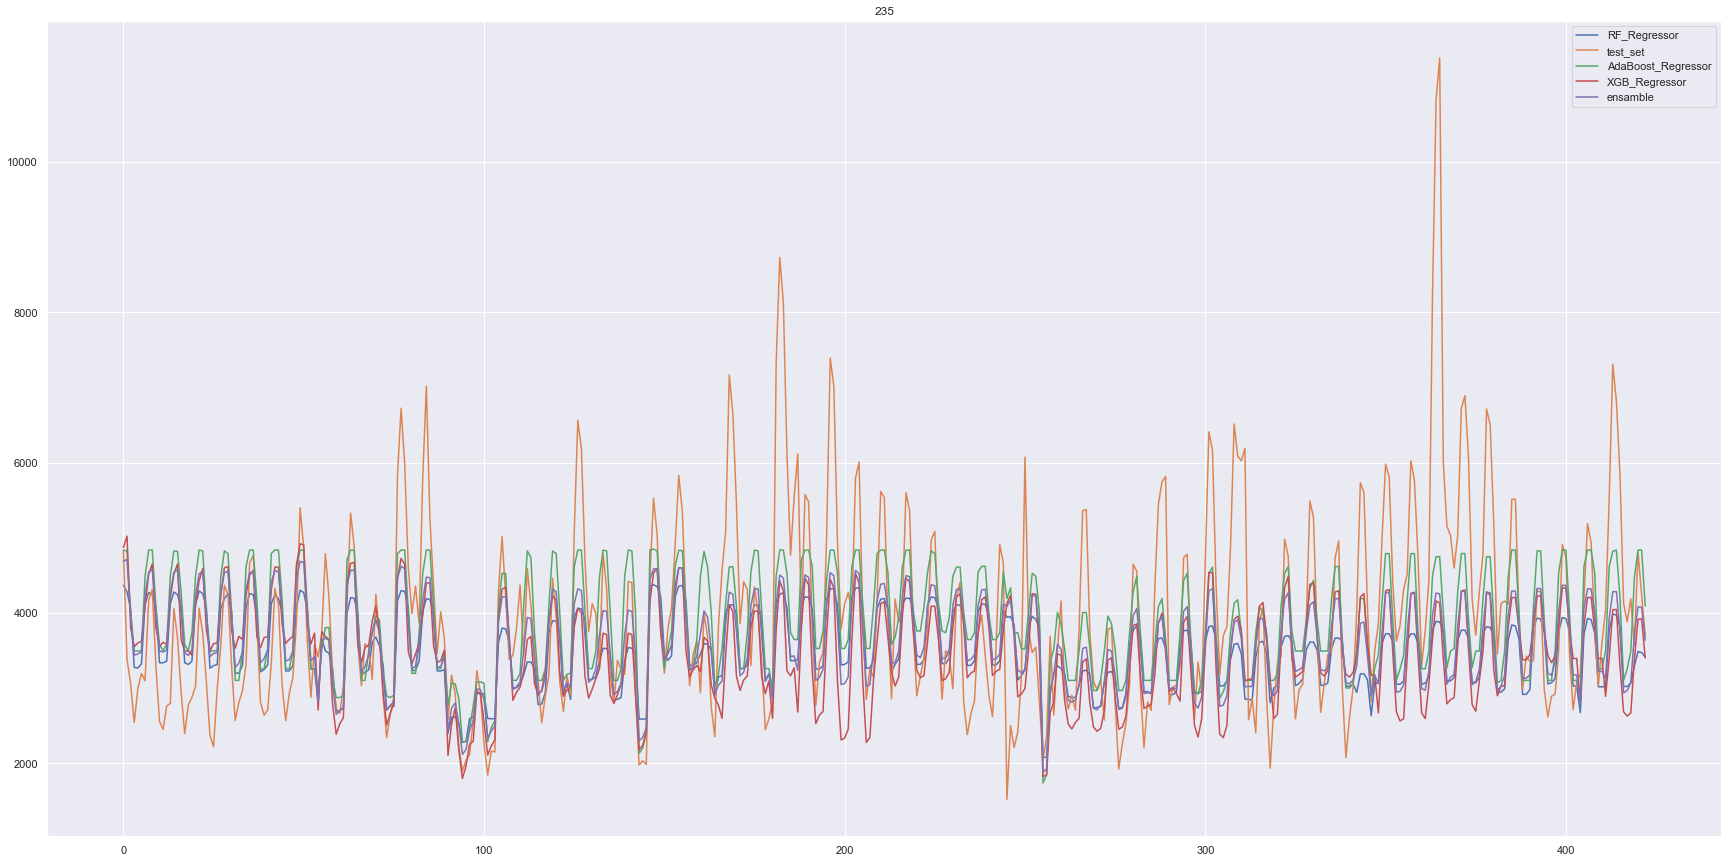

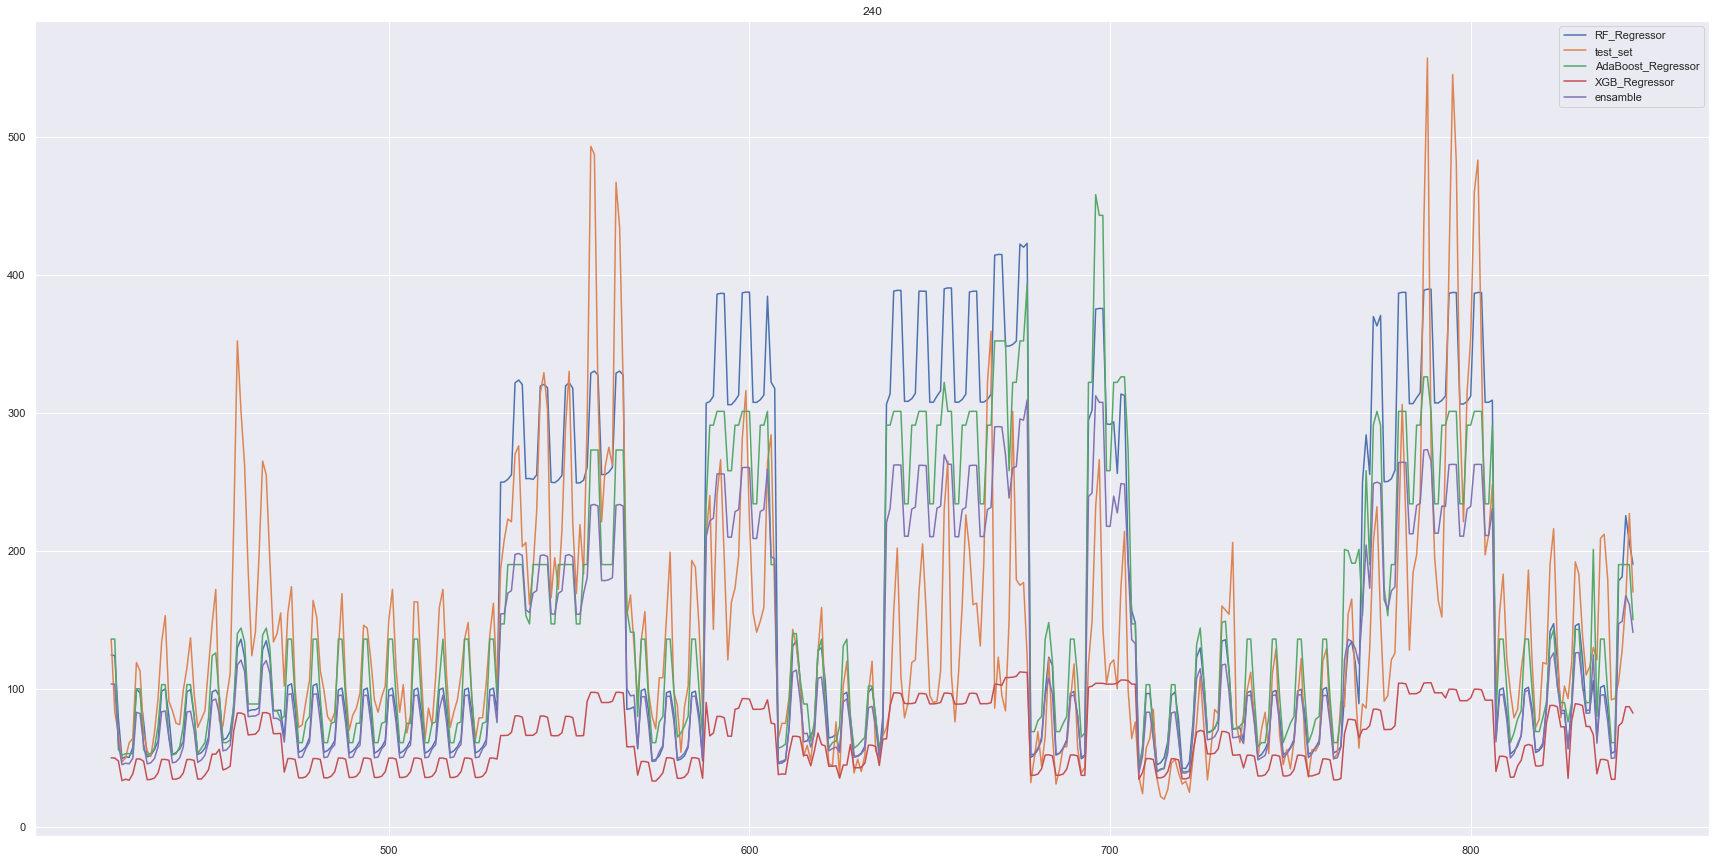

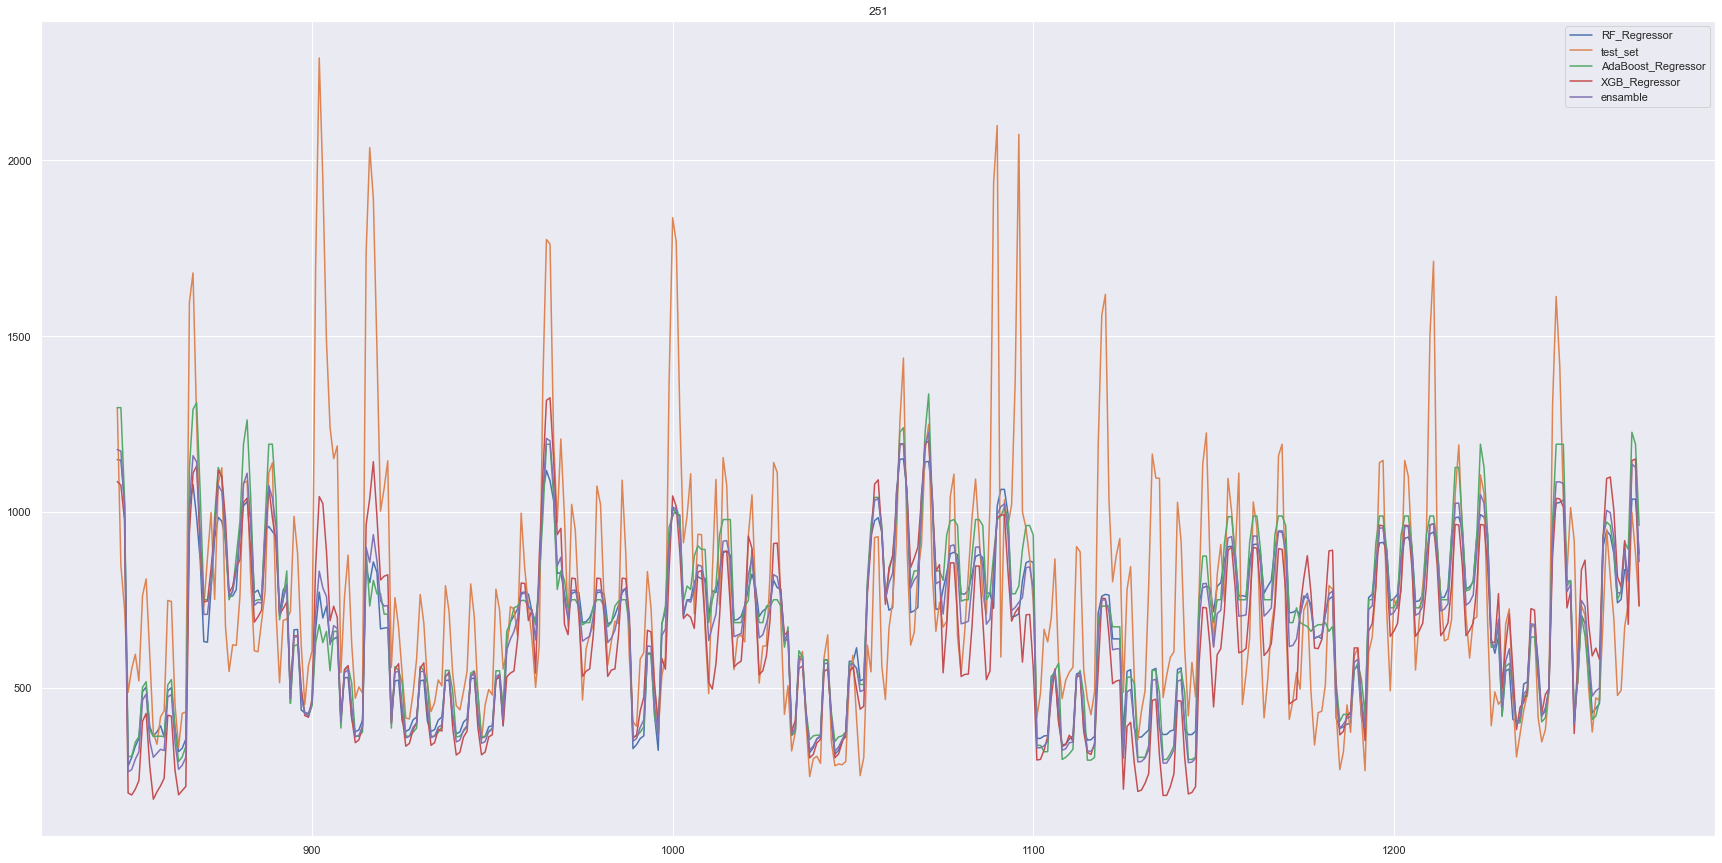

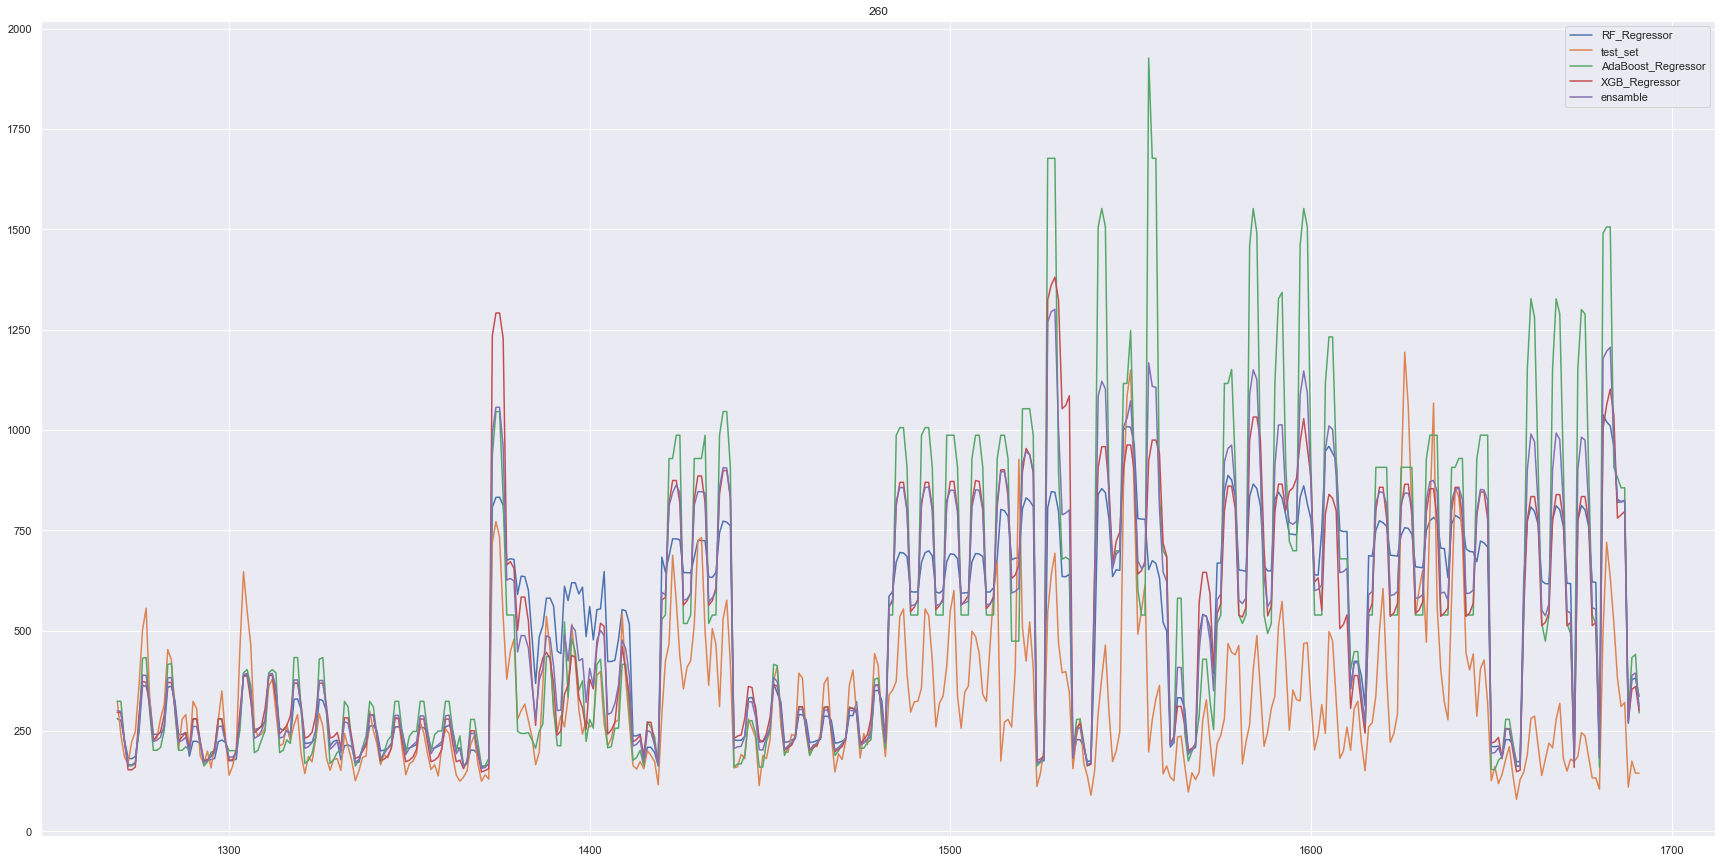

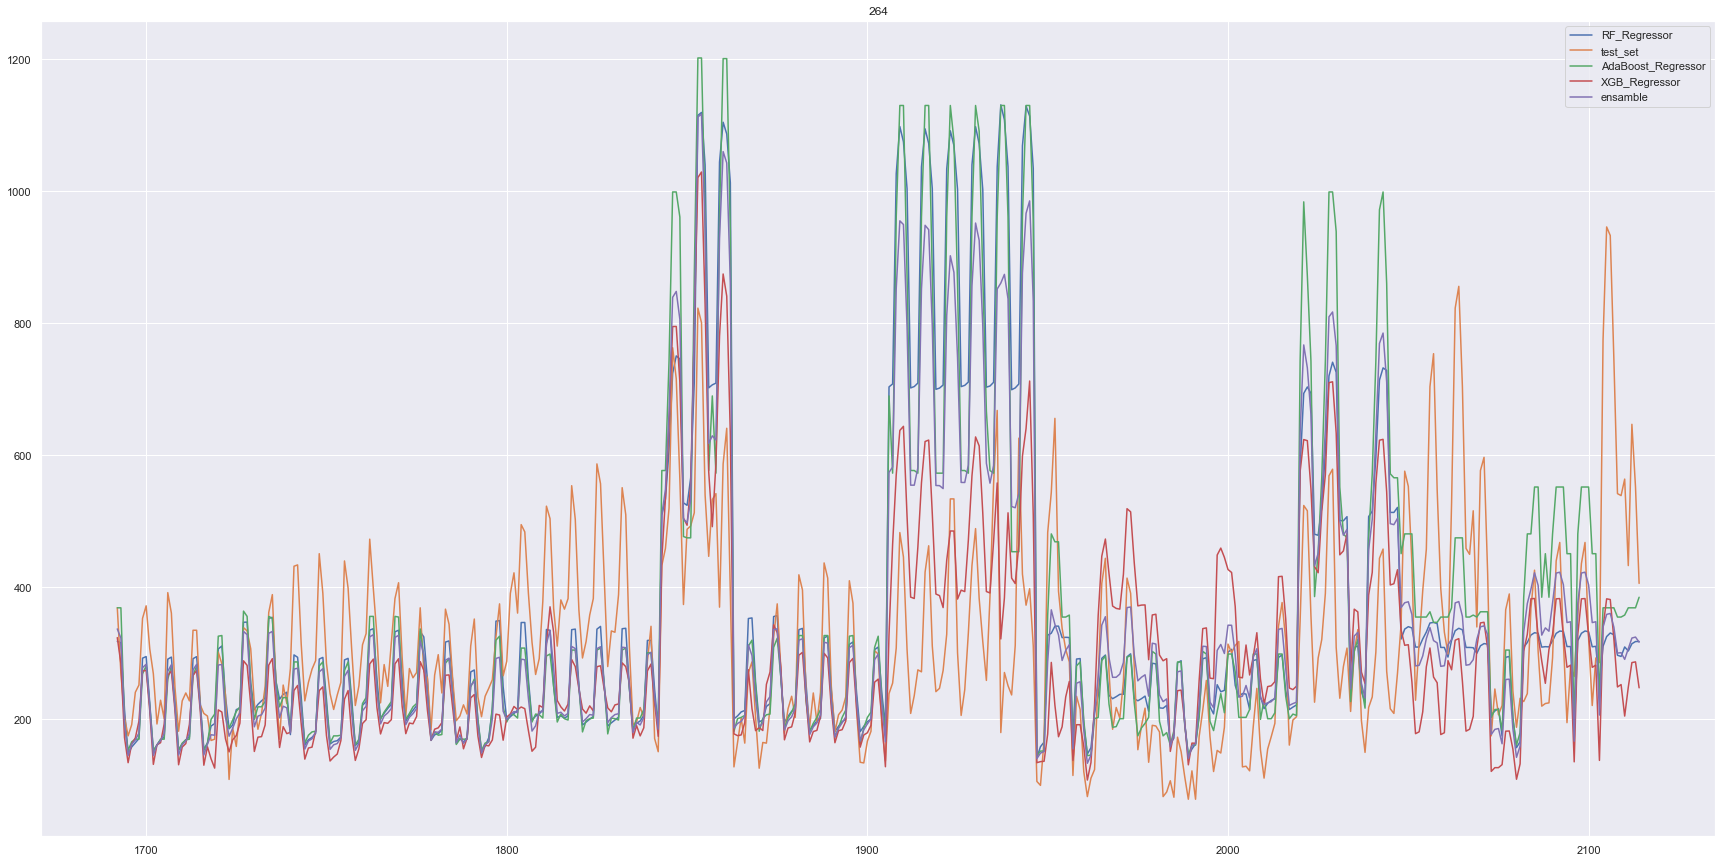

In [661]:
# Обучаем ниши модели. Задаем кол-во итераций RandomizeSearch, кол-во фолдов кросс-валидации и запись (не запись) в pickle
obj_test.fitModel(20, 3, False)

In [662]:
# Просмотр прогнозов для тренировочной выборки через call-объект
obj_test.callTrainPredReaport()

{'RF_Regressor': {235: array([1360.05134193, 1197.67927671, 1223.9406489 , ..., 2500.85073689,
         4144.012192  , 4366.51088495]),
  240: array([  1.44143908,   0.54473104,   0.68766723, ...,  56.25463401,
          74.63085829, 124.52502734]),
  251: array([ 203.77673561,  155.84700586,  154.08142745, ...,  881.12187416,
         1112.75169282, 1149.21480399]),
  260: array([157.82755543, 138.85347242, 142.0159495 , ..., 211.02717308,
         231.30888095, 280.63553968]),
  264: array([121.91093364,  94.11192727, 102.14250188, ..., 197.04990429,
         228.14361781, 318.18532094])},
 'train_set': {235: array([ 833., 1166., 1082., ..., 2875., 4837., 4825.]),
  240: array([  0.,   0.,   0., ...,  53.,  88., 136.]),
  251: array([ 110.,  165.,  131., ...,  938., 1227., 1297.]),
  260: array([ 79., 136., 116., ..., 197., 271., 324.]),
  264: array([ 80.,  86.,  98., ..., 190., 290., 369.])},
 'AdaBoost_Regressor': {235: array([1410., 1134., 1252., ..., 2469., 4837., 4837.]),
  240

In [663]:
# Просмотр прогнозов для тестовой выборки через call-объект
obj_test.callTestPredReaport()

{'RF_Regressor': {235: array([4366.51088495, 4279.99325591, 4057.66155024, 3274.84569352,
         3267.15902686, 3323.87610028, 4121.11618917, 4270.82885486,
         4243.75146925, 4087.87303039, 3337.33422094, 3337.33422094,
         3359.10738203, 4124.77758996, 4278.91882708, 4242.84944147,
         4079.07975262, 3337.33422094, 3314.82785731, 3357.63324567,
         4109.69591482, 4292.41508701, 4256.34570139, 4077.48913067,
         3264.71108942, 3298.64983401, 3313.36770658, 4056.71014052,
         4191.61778877, 4253.13858608, 4023.58165569, 3198.33733815,
         3200.49867148, 3294.39530903, 4076.37222102, 4257.70346667,
         4244.14044469, 3959.42315091, 3216.4521114 , 3245.76122251,
         3310.14001358, 4122.817823  , 4240.56148823, 4187.40113292,
         4018.92729376, 3228.5533614 , 3230.71469473, 3295.0934858 ,
         4081.42961788, 4301.77598318, 4270.67768848, 4038.69288351,
         3255.45313918, 3257.61447251, 2795.68457629, 3653.57364274,
         3495

      index RF_Regressor  test_set AdaBoost_Regressor XGB_Regressor  ensamble
0       235    4,366.511 4,825.000          4,837.000     4,870.886 4,691.466
1       235    4,279.993 3,384.000          4,825.000     5,021.906 4,708.967
2       235    4,057.662 3,061.000          4,006.000     3,805.209 3,956.290
3       235    3,274.846 2,543.000          3,493.000     3,550.852 3,439.566
4       235    3,267.159 2,992.000          3,493.000     3,600.645 3,453.601
...     ...          ...       ...                ...           ...       ...
2110    264      309.725   564.000            358.000       204.999   290.908
2111    264      303.573   433.000            369.000       248.796   307.123
2112    264      314.573   647.000            369.000       286.036   323.203
2113    264      317.912   552.000            369.000       287.105   324.672
2114    264      317.996   406.000            385.000       247.810   316.936

[2115 rows x 6 columns]


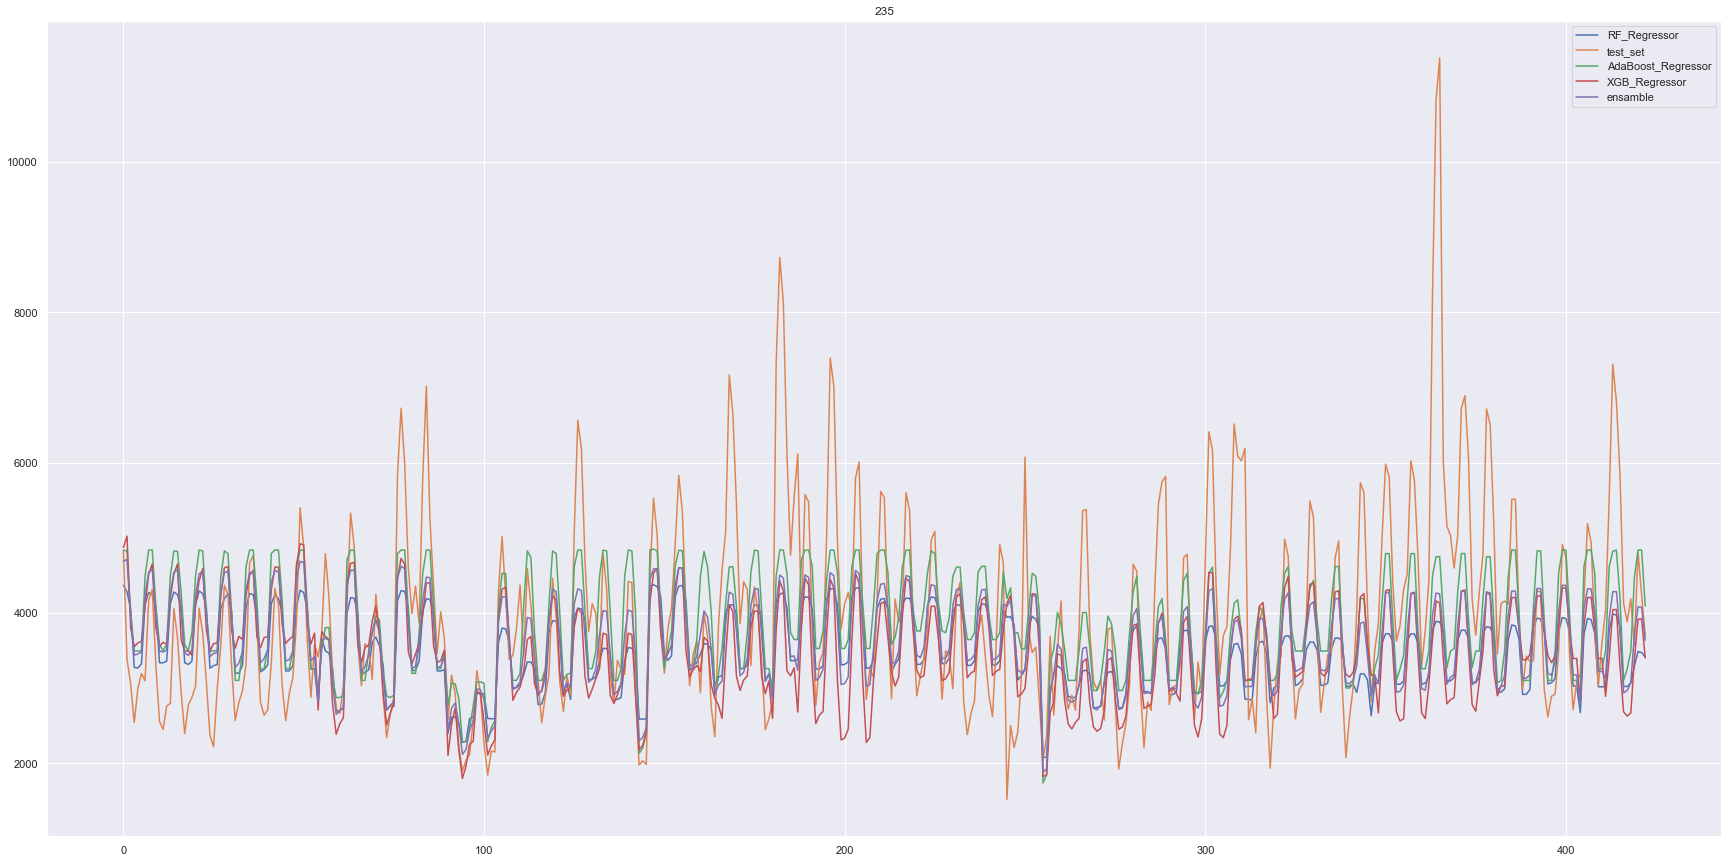

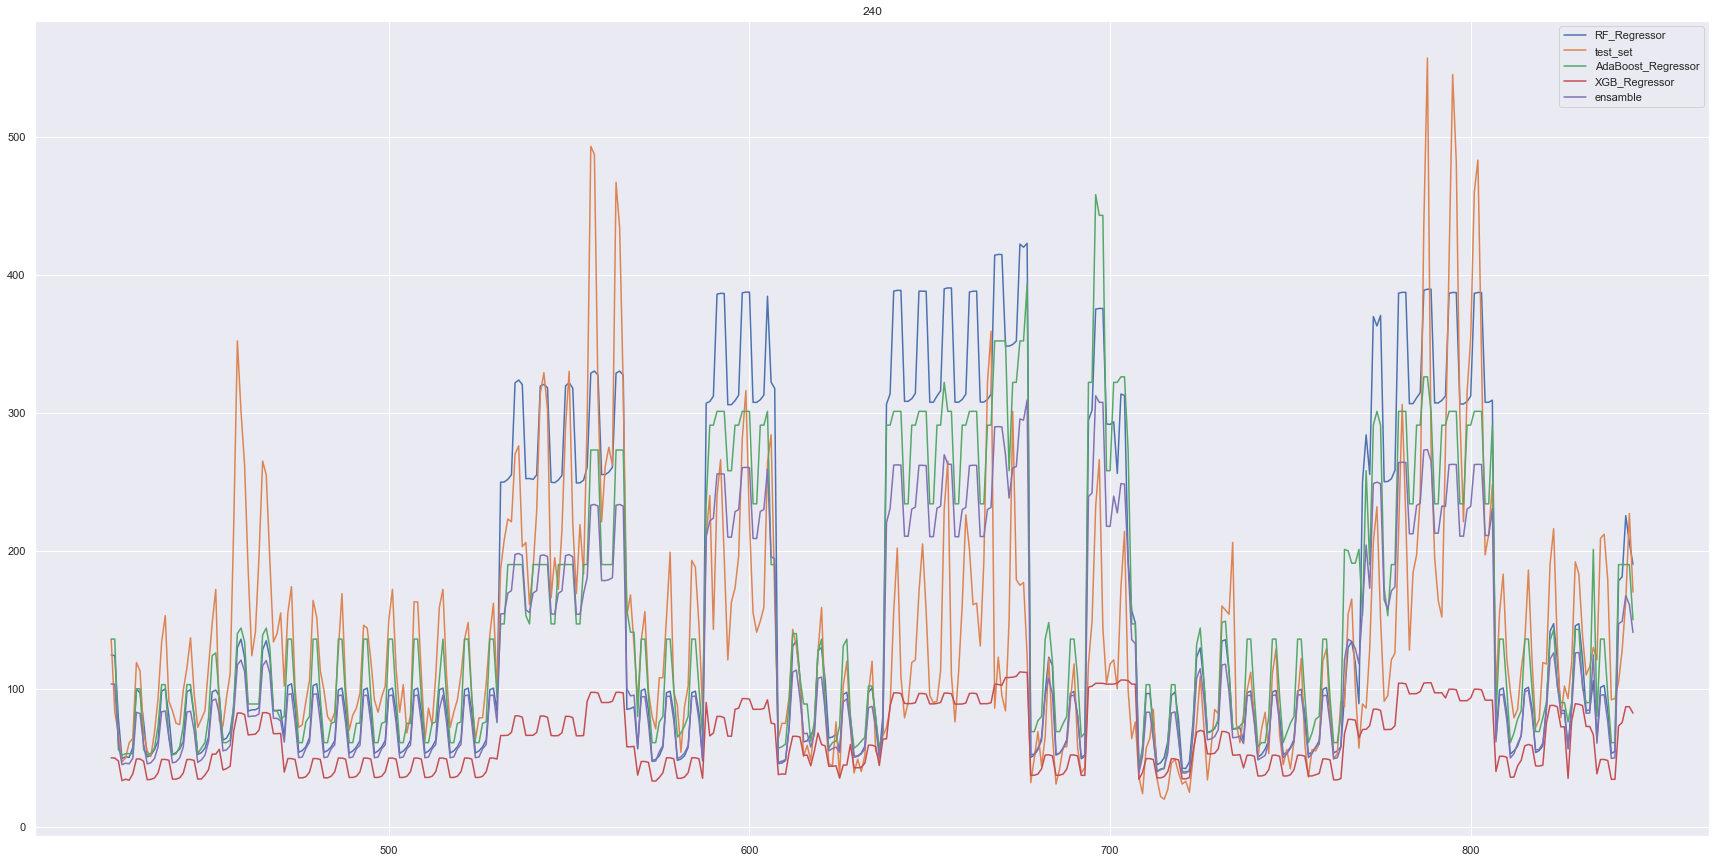

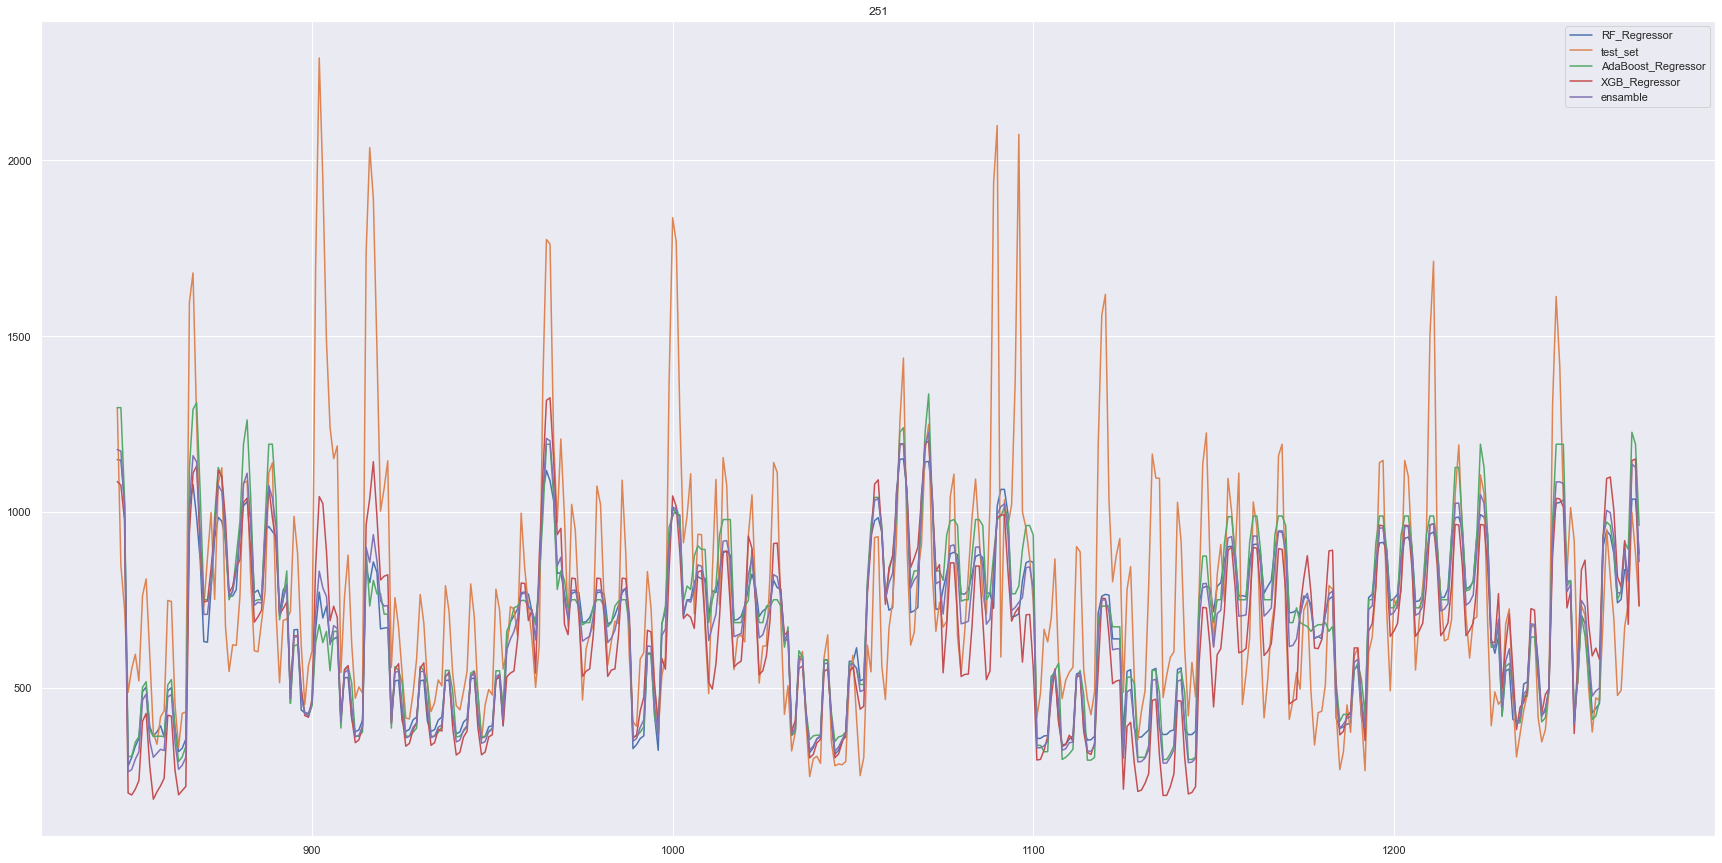

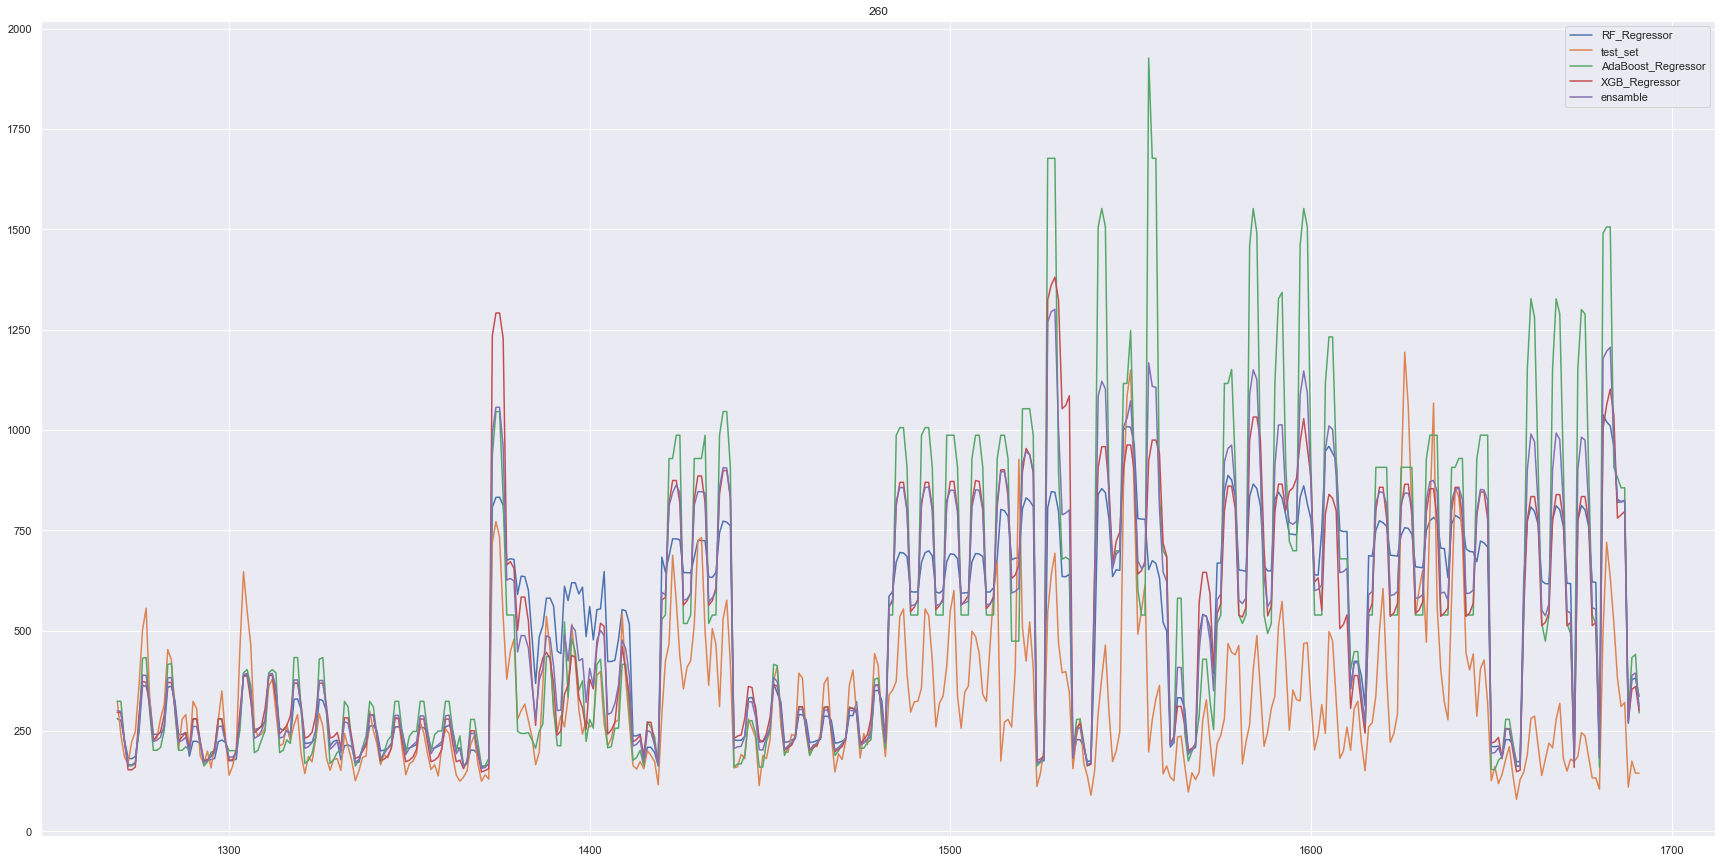

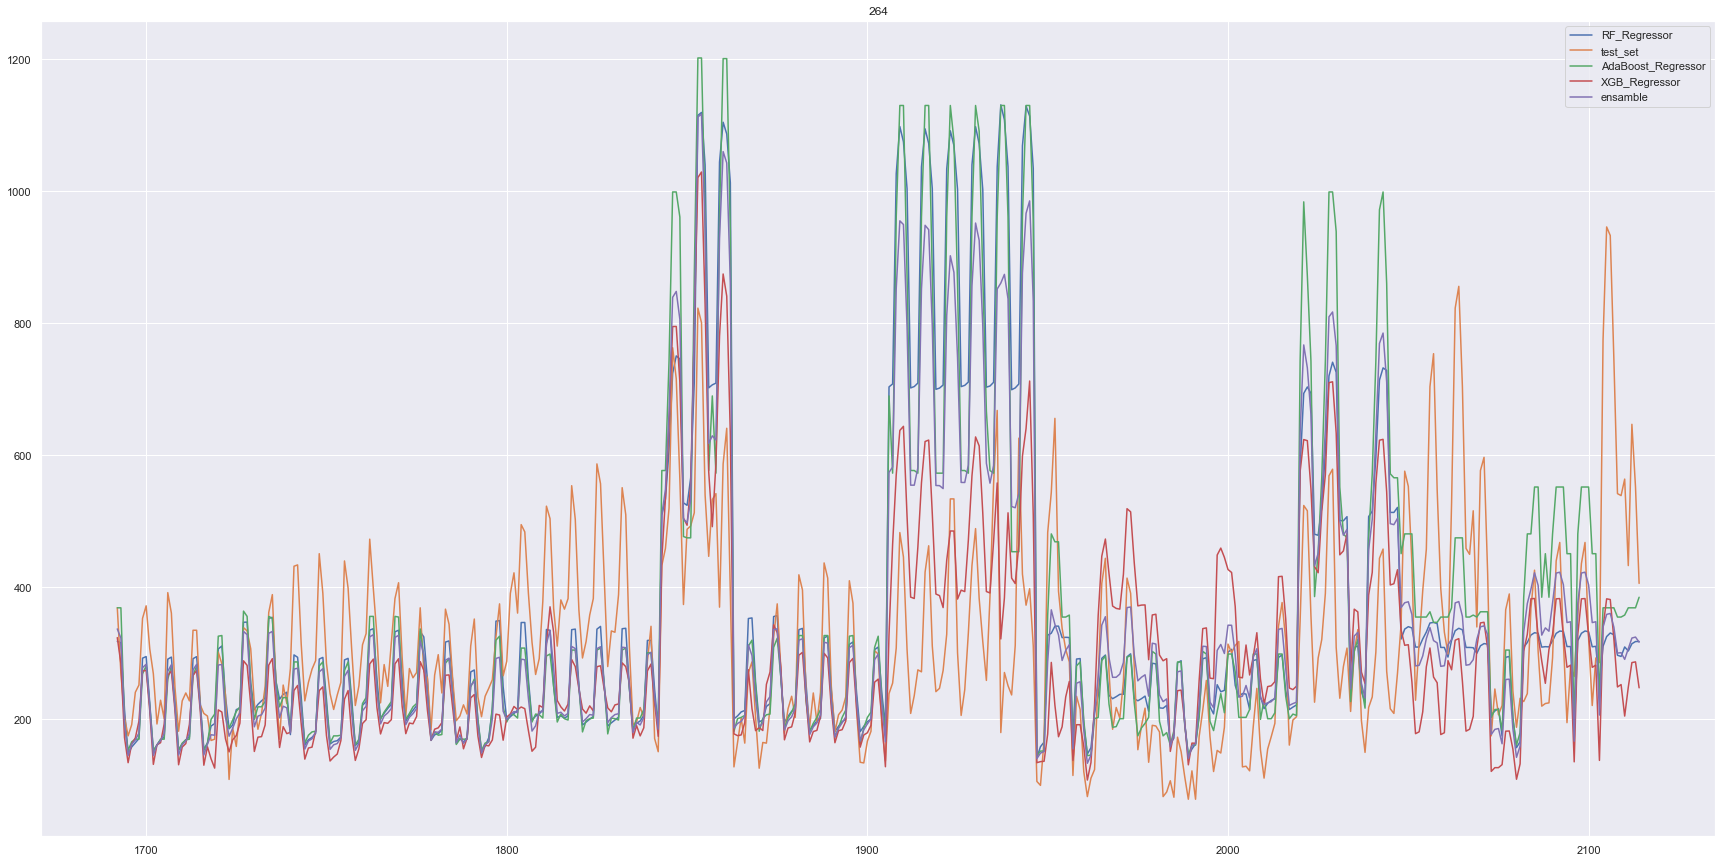

In [664]:
# просмотр прогнозных графиков тестовой выборки
obj_test.callPlotsTest()

In [665]:
#Проверка: вычитываем лучшие эстиматоры из файлов
pd.read_csv(f'save_best_estimators_params/best_models_params_{today}.csv')

Unnamed: 0                                       RF_Regressor  \
0         235  {'n_estimators': 100, 'min_samples_split': 10,...   
1         240  {'n_estimators': 600, 'min_samples_split': 2, ...   
2         251  {'n_estimators': 600, 'min_samples_split': 2, ...   
3         260  {'n_estimators': 100, 'min_samples_split': 10,...   
4         264  {'n_estimators': 600, 'min_samples_split': 2, ...   

                                  AdaBoost_Regressor  \
0  {'n_estimators': 100, 'learning_rate': 2.0, 'b...   
1  {'n_estimators': 250, 'learning_rate': 1.0, 'b...   
2  {'n_estimators': 250, 'learning_rate': 1.0, 'b...   
3  {'n_estimators': 200, 'learning_rate': 0.5, 'b...   
4  {'n_estimators': 250, 'learning_rate': 1.0, 'b...   

                                       XGB_Regressor  
0  {'subsample': 0.8, 'reg_lambda': 10, 'reg_alph...  
1  {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha...  
2  {'subsample': 0.6, 'reg_lambda': 100, 'reg_alp...  
3  {'subsample': 0.6, 'reg_lambda': 0.001, 'reg_a...  
4  {'subsample': 0.5, 'reg_lambda': 100, 'reg_alp...

In [654]:
#Проверка: вычитка метрик на трейне
pd.read_csv(f'save_metrics_csv/metrics_all_models_train_{today}.csv')

Unnamed: 0  index metric  _RF_Regressor  _Ridge_Regressor  _XGB_Regressor  \
0            0    235    MAE        107.466           645.738          46.799   
1            1    235   RMSE        156.279           886.605          85.680   
2            2    235     R2          0.976            -0.952           0.994   
3            3    235   MAPE          5.033            30.131           2.300   
4            4    235  MedAE         75.255           480.509          25.385   
5            5    235    MSE     24,423.080       786,067.767       7,341.097   
6            6    240    MAE          6.917            19.958          17.067   
7            7    240   RMSE         16.970            35.197          31.516   
8            8    240     R2          0.908             0.472           0.249   
9            9    240   MAPE         25.441           143.719          57.639   
10          10    240  MedAE          2.977            10.282           9.975   
11          11    240    MSE        287.972         1,238.852         993.270   
12          12    251    MAE         38.422           148.174           3.568   
13          13    251   RMSE         60.934           205.591           7.051   
14          14    251     R2          0.950             0.034           0.999   
15          15    251   MAPE          8.753            35.285           0.892   
16          16    251  MedAE         23.020           109.203           1.861   
17          17    251    MSE      3,712.948        42,267.718          49.720   
18          18    260    MAE         30.076            98.679           3.154   
19          19    260   RMSE         51.415           151.080           8.585   
20          20    260     R2          0.950             0.426           0.999   
21          21    260   MAPE         10.881            44.654           1.096   
22          22    260  MedAE         18.685            69.547           1.368   
23          23    260    MSE      2,643.510        22,825.201          73.705   
24          24    264    MAE         26.547           114.023          17.823   
25          25    264   RMSE         48.840           185.280          44.516   
26          26    264     R2          0.952            -0.438           0.960   
27          27    264   MAPE          9.576            50.863           6.495   
28          28    264  MedAE         15.244            75.038           9.349   
29          29    264    MSE      2,385.301        34,328.725       1,981.660   

    _Lasso_Regressor  
0            616.285  
1            853.691  
2             -0.795  
3             28.620  
4            441.155  
5        728,789.105  
6             20.033  
7             35.127  
8              0.474  
9            107.640  
10            10.455  
11         1,233.875  
12           119.438  
13           171.036  
14             0.470  
15            28.656  
16            89.087  
17        29,253.360  
18            87.341  
19           137.079  
20             0.565  
21            63.903  
22            58.524  
23        18,790.701  
24           102.444  
25           171.399  
26            -0.078  
27            45.972  
28            69.456  
29        29,377.664

In [655]:
#Проверка: вычитка метрик на тесте
pd.read_csv(f'save_metrics_csv/metrics_all_models_test_{today}.csv')

Unnamed: 0  index metric  _RF_Regressor  _Ridge_Regressor  _XGB_Regressor  \
0            0    235    MAE        803.145           964.276         844.137   
1            1    235   RMSE      1,152.006         1,323.260       1,214.934   
2            2    235     R2         -3.819            -6.318          -2.424   
3            3    235   MAPE         21.672            25.890          24.228   
4            4    235  MedAE        566.463           780.549         608.645   
5            5    235    MSE  1,327,118.769     1,751,016.899   1,476,065.408   
6            6    240    MAE         65.732            59.841          60.017   
7            7    240   RMSE         94.606            86.668          77.318   
8            8    240     R2          0.389            -1.690           0.152   
9            9    240   MAPE         40.039            43.520          75.299   
10          10    240  MedAE         36.781            43.440          50.859   
11          11    240    MSE      8,950.368         7,511.420       5,978.079   
12          12    251    MAE        197.311           274.727         224.331   
13          13    251   RMSE        288.302           344.608         315.085   
14          14    251     R2         -0.715            -1.431          -1.137   
15          15    251   MAPE         30.226            30.042          42.709   
16          16    251  MedAE        149.467           252.929         160.829   
17          17    251    MSE     83,118.329       118,754.387      99,278.539   
18          18    260    MAE        192.736           197.411         189.472   
19          19    260   RMSE        255.903           250.541         273.570   
20          20    260     R2         -0.140            -0.220           0.020   
21          21    260   MAPE         33.948            96.214          31.996   
22          22    260  MedAE        154.647           156.492          91.089   
23          23    260    MSE     65,486.354        62,770.688      74,840.571   
24          24    264    MAE        147.859           159.543         120.068   
25          25    264   RMSE        232.863           197.169         154.441   
26          26    264     R2          0.097            -0.026           0.021   
27          27    264   MAPE         35.904           234.239          42.834   
28          28    264  MedAE         78.205           138.798          94.645   
29          29    264    MSE     54,225.092        38,875.427      23,851.983   

    _Lasso_Regressor  
0            906.885  
1          1,283.313  
2             -6.803  
3             25.022  
4            658.937  
5      1,646,892.140  
6             60.183  
7             84.676  
8             -1.274  
9             40.953  
10            45.897  
11         7,169.961  
12           246.310  
13           313.468  
14            -0.306  
15            29.201  
16           201.210  
17        98,262.454  
18           237.647  
19           285.028  
20            -0.051  
21           128.404  
22           202.814  
23        81,241.188  
24           298.467  
25           369.299  
26            -0.163  
27           776.647  
28           245.242  
29       136,381.889

In [656]:
#Проверка: вычитка прогнозных значений на трейне
pd.read_csv(f'save_predicts_train_csv/pedicts_all_models_train_{today}.csv')

index  RF_Regressor  train_set  Ridge_Regressor  XGB_Regressor  \
0       235     1,069.870    833.000        1,533.477        885.500   
1       235     1,137.818  1,166.000        1,533.379      1,074.216   
2       235     1,128.765  1,082.000        1,530.048      1,062.888   
3       235     1,256.693  1,252.000        1,526.572      1,315.896   
4       235     4,156.095  3,805.000        2,775.659      4,018.016   
...     ...           ...        ...              ...            ...   
6080    264       149.798    143.000          278.481        131.856   
6081    264       178.654    166.000          275.474        176.615   
6082    264       196.693    190.000          271.103        192.424   
6083    264       224.425    290.000          272.234        251.669   
6084    264       318.510    369.000          272.376        323.855   

      Lasso_Regressor  ensamble  
0           1,533.461 1,255.577  
1           1,328.239 1,268.413  
2           1,357.254 1,269.739  
3           1,387.691 1,371.713  
4           2,598.967 3,387.184  
...               ...       ...  
6080          185.867   186.500  
6081          191.829   205.643  
6082          189.476   212.424  
6083          196.224   236.138  
6084          197.856   278.149  

[6085 rows x 7 columns]

In [657]:
#Проверка: вычиитка прогнозных значений на тесте
pd.read_csv(f'save_predicts_test_csv/pedicts_all_models_test_{today}.csv')

index  RF_Regressor  test_set  Ridge_Regressor  XGB_Regressor  \
0       235     4,618.153 4,825.000        3,613.469      4,870.886   
1       235     4,522.382 3,384.000        3,567.343      5,021.906   
2       235     4,167.340 3,061.000        3,552.287      3,805.209   
3       235     3,271.088 2,543.000        3,668.275      3,550.852   
4       235     3,249.090 2,992.000        3,633.839      3,600.645   
...     ...           ...       ...              ...            ...   
2110    264       306.960   564.000          437.836        204.999   
2111    264       311.562   433.000          428.137        248.796   
2112    264       327.437   647.000          425.311        286.036   
2113    264       330.770   552.000          420.055        287.105   
2114    264       331.005   406.000          412.729        247.810   

      Lasso_Regressor  ensamble  
0           3,339.142 4,110.412  
1           3,334.685 4,111.579  
2           3,351.722 3,719.140  
3           3,369.710 3,464.981  
4           3,353.040 3,459.153  
...               ...       ...  
2110         -305.663   161.033  
2111         -254.337   183.539  
2112         -249.609   197.294  
2113         -251.174   196.689  
2114         -264.103   181.860  

[2115 rows x 7 columns]

# Закончил тут!